# Performance Analysis with Alphalens

This notebook uses the environment `ml4t-zipline`.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [3]:
sns.set_style('whitegrid')

In [4]:
np.random.seed(42)
idx = pd.IndexSlice

In [5]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Alphalens Analysis

### Load predictions

In [6]:
DATA_STORE = Path(results_path / 'data.h5')

In [15]:
predictions = pd.read_hdf(results_path / 'predictions.h5', 'predictions_avg')

In [16]:
factor = (predictions
          .unstack('ticker')
#           .resample('W-FRI')
#           .last()
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()

### Get trade prices

In [9]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2014':'2020'], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [10]:
trade_prices = get_trade_prices(tickers)

In [11]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2014-01-02 to 2019-12-31
Columns: 3657 entries, A to ZYME
dtypes: float64(3657)
memory usage: 42.1 MB


### Generate tearsheet input

In [17]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(5, 10, 21)).sort_index()
factor_data.info()

Dropped 18.7% entries from factor data: 18.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 772743 entries, (2015-01-09 00:00:00+00:00, A) to (2019-11-22 00:00:00+00:00, ZYME)
Data columns (total 5 columns):
5D                 772743 non-null float64
10D                772743 non-null float64
21D                772743 non-null float64
factor             772743 non-null float32
factor_quantile    772743 non-null int64
dtypes: float32(1), float64(3), int64(1)
memory usage: 29.5+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.885846,0.004321,-0.089928,0.057091,154650,20.013122
2,-0.134505,0.021237,-0.034410,0.021910,154502,19.993970
3,-0.076786,0.064423,-0.003905,0.018935,154488,19.992158
4,-0.035235,0.124208,0.026504,0.021409,154502,19.993970
5,-0.002385,0.400657,0.077615,0.043736,154601,20.006781


Returns Analysis


,5D,10D,21D
Ann. alpha,0.022,0.012,0.015
beta,-0.066,-0.033,-0.065
Mean Period Wise Return Top Quantile (bps),4.377,3.156,3.203
Mean Period Wise Return Bottom Quantile (bps),-3.173,-0.943,-0.438
Mean Period Wise Spread (bps),7.551,4.096,3.630


Information Analysis


,5D,10D,21D
IC Mean,0.006,0.006,0.009
IC Std.,0.092,0.088,0.086
Risk-Adjusted IC,0.067,0.070,0.101
t-stat(IC),1.060,1.104,1.586
p-value(IC),0.290,0.271,0.114
IC Skew,0.133,0.278,0.348
IC Kurtosis,0.888,0.014,-0.085


Turnover Analysis


,5D,10D,21D
Quantile 1 Mean Turnover,0.538,0.628,0.747
Quantile 2 Mean Turnover,0.717,0.749,0.782
Quantile 3 Mean Turnover,0.741,0.767,0.788
Quantile 4 Mean Turnover,0.718,0.754,0.786
Quantile 5 Mean Turnover,0.547,0.629,0.728


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.493,0.348,0.142


<Figure size 432x288 with 0 Axes>

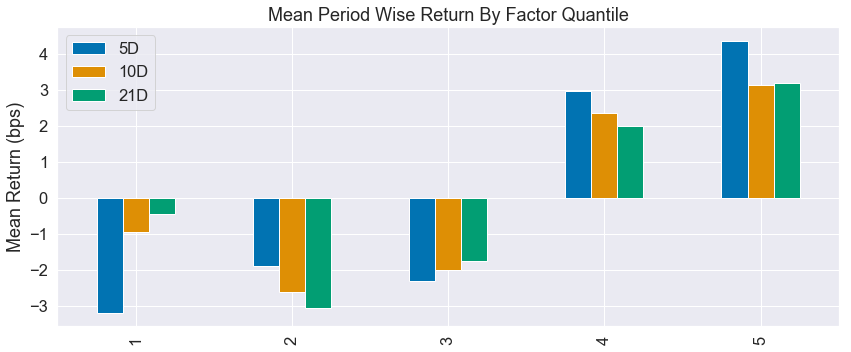

In [18]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.885846,0.004321,-0.089928,0.057091,154650,20.013122
2,-0.134505,0.021237,-0.034410,0.021910,154502,19.993970
3,-0.076786,0.064423,-0.003905,0.018935,154488,19.992158
4,-0.035235,0.124208,0.026504,0.021409,154502,19.993970
5,-0.002385,0.400657,0.077615,0.043736,154601,20.006781


Returns Analysis


,5D,10D,21D
Ann. alpha,0.022,0.012,0.015
beta,-0.066,-0.033,-0.065
Mean Period Wise Return Top Quantile (bps),4.377,3.156,3.203
Mean Period Wise Return Bottom Quantile (bps),-3.173,-0.943,-0.438
Mean Period Wise Spread (bps),7.551,4.096,3.630


<Figure size 432x288 with 0 Axes>

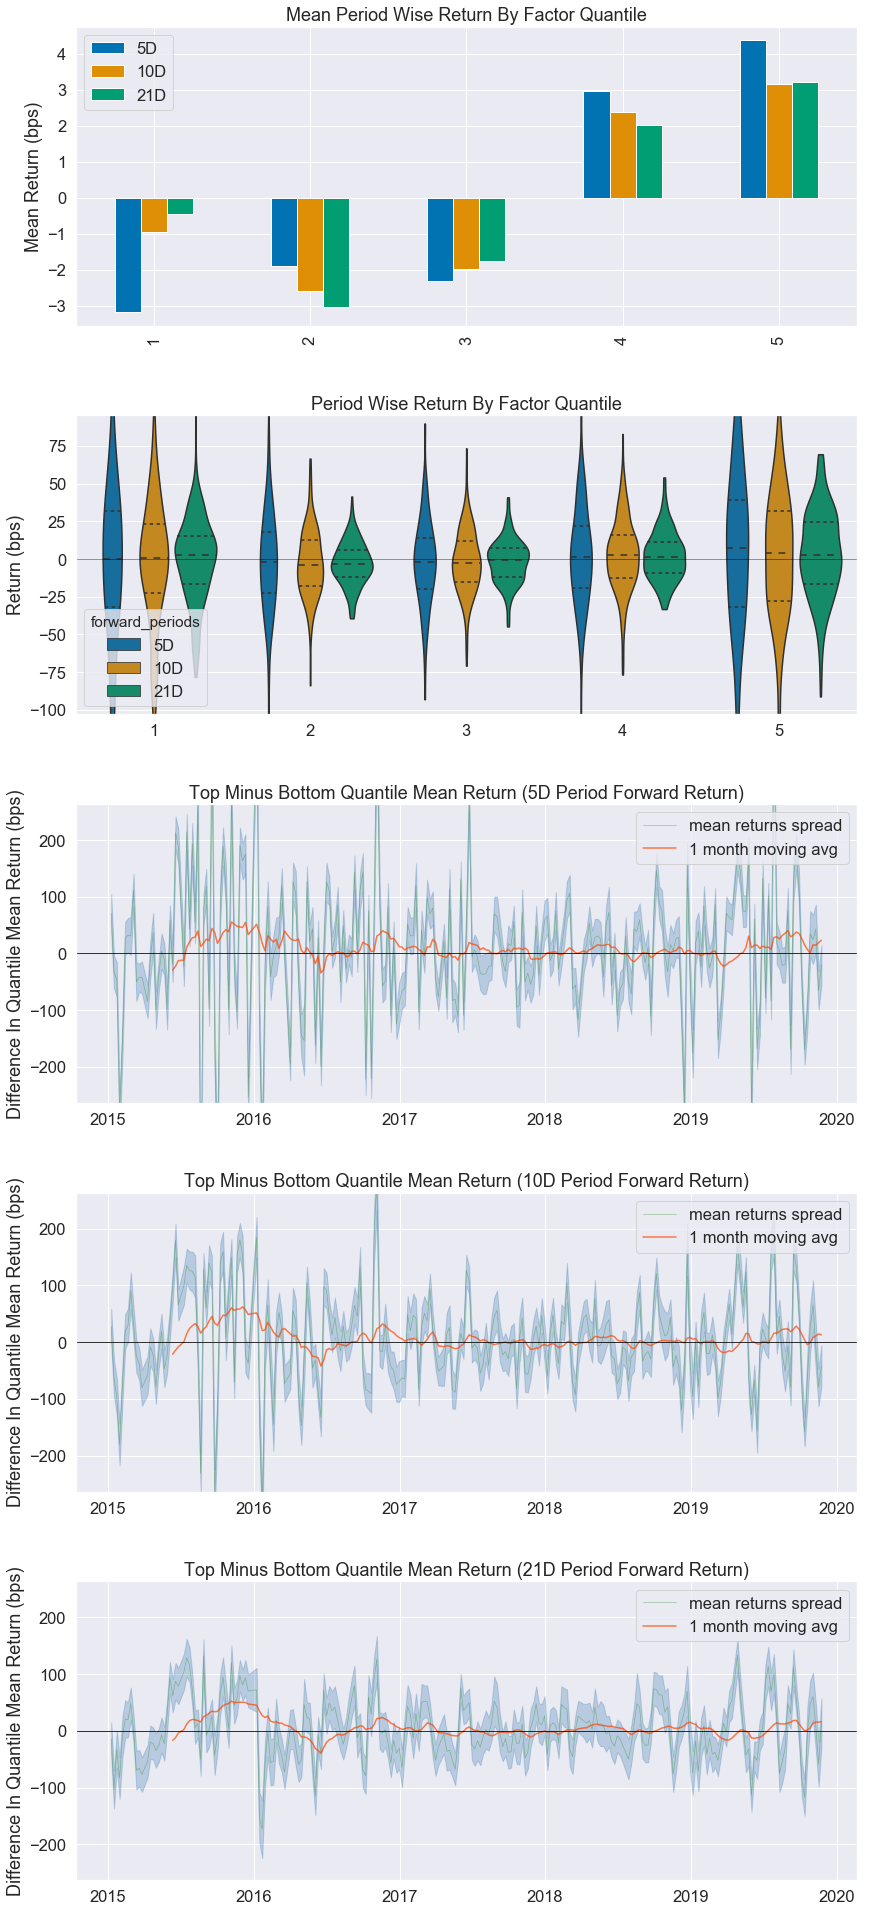

Information Analysis


,5D,10D,21D
IC Mean,0.006,0.006,0.009
IC Std.,0.092,0.088,0.086
Risk-Adjusted IC,0.067,0.070,0.101
t-stat(IC),1.060,1.104,1.586
p-value(IC),0.290,0.271,0.114
IC Skew,0.133,0.278,0.348
IC Kurtosis,0.888,0.014,-0.085


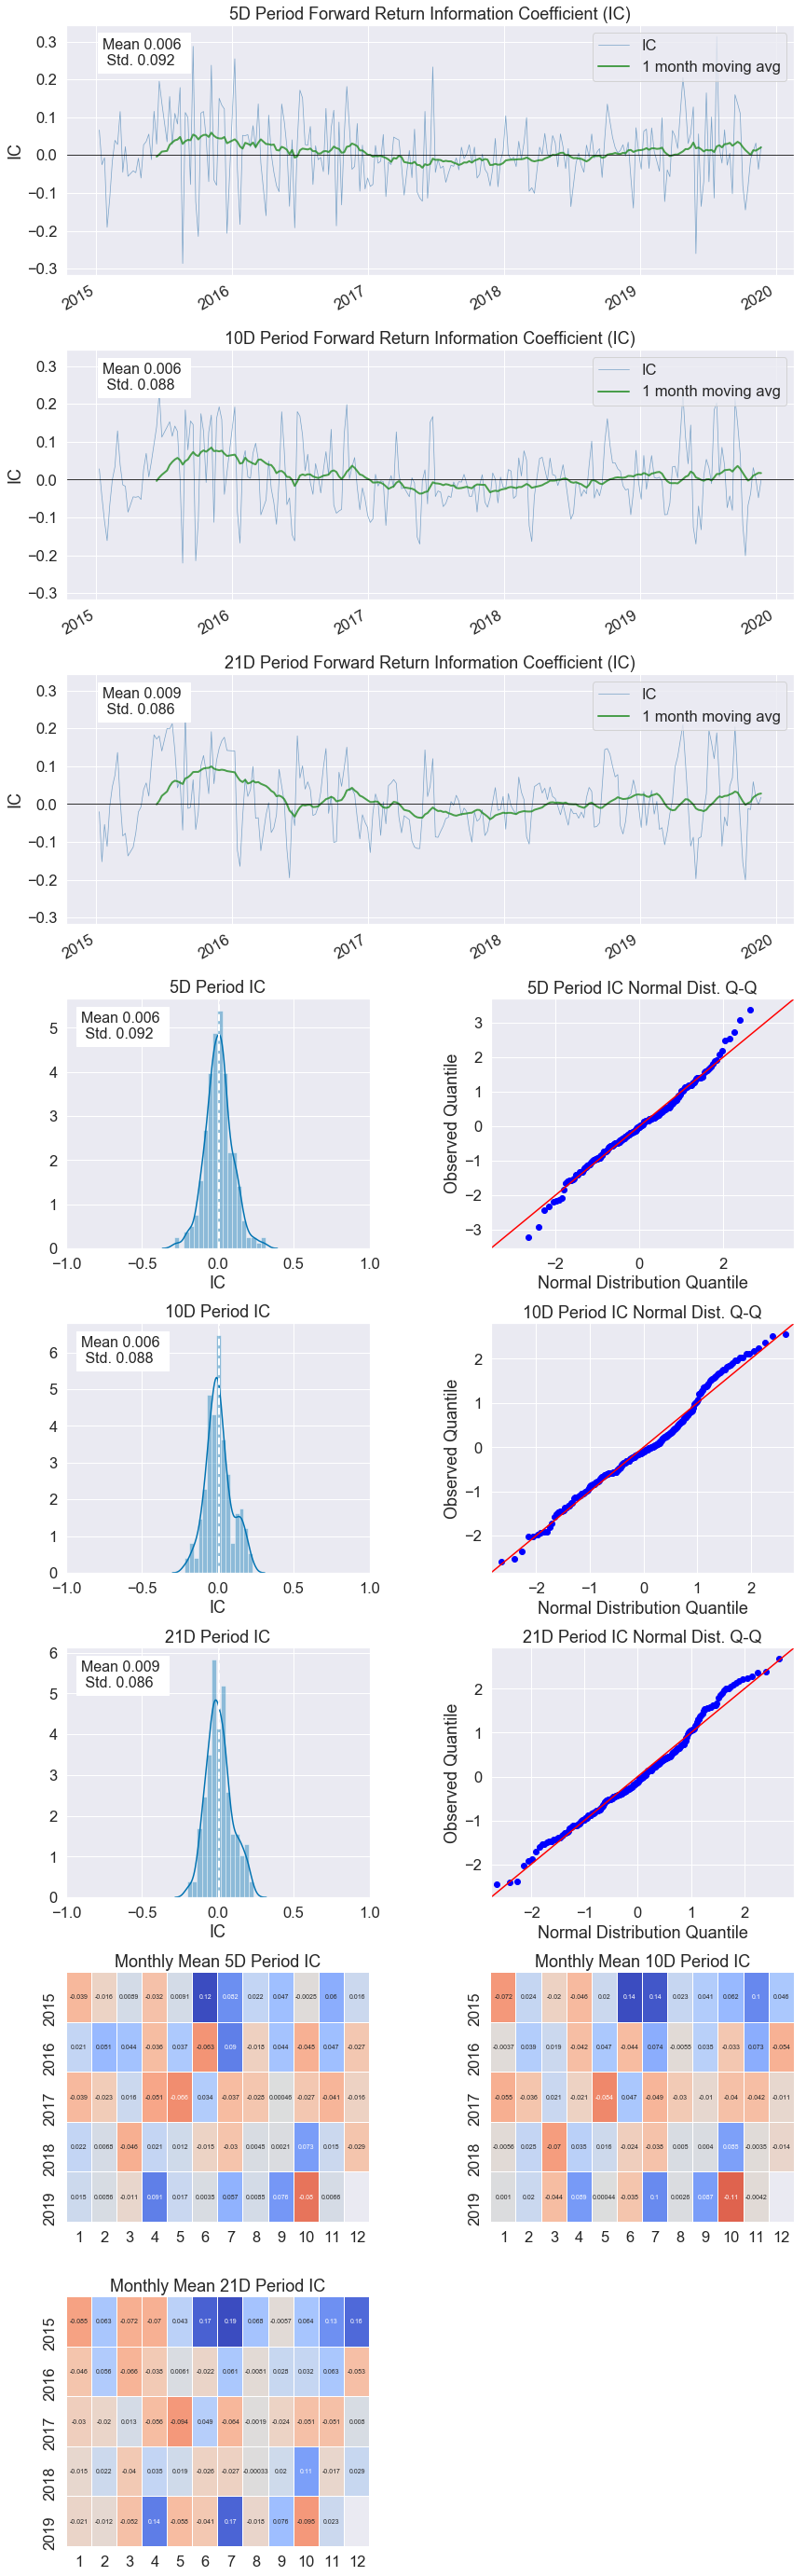

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t-zipline/lib/python3.5/site-packages/alphalens/utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,5D,10D,21D
Quantile 1 Mean Turnover,0.538,0.628,0.747
Quantile 2 Mean Turnover,0.717,0.749,0.782
Quantile 3 Mean Turnover,0.741,0.767,0.788
Quantile 4 Mean Turnover,0.718,0.754,0.786
Quantile 5 Mean Turnover,0.547,0.629,0.728


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.493,0.348,0.142


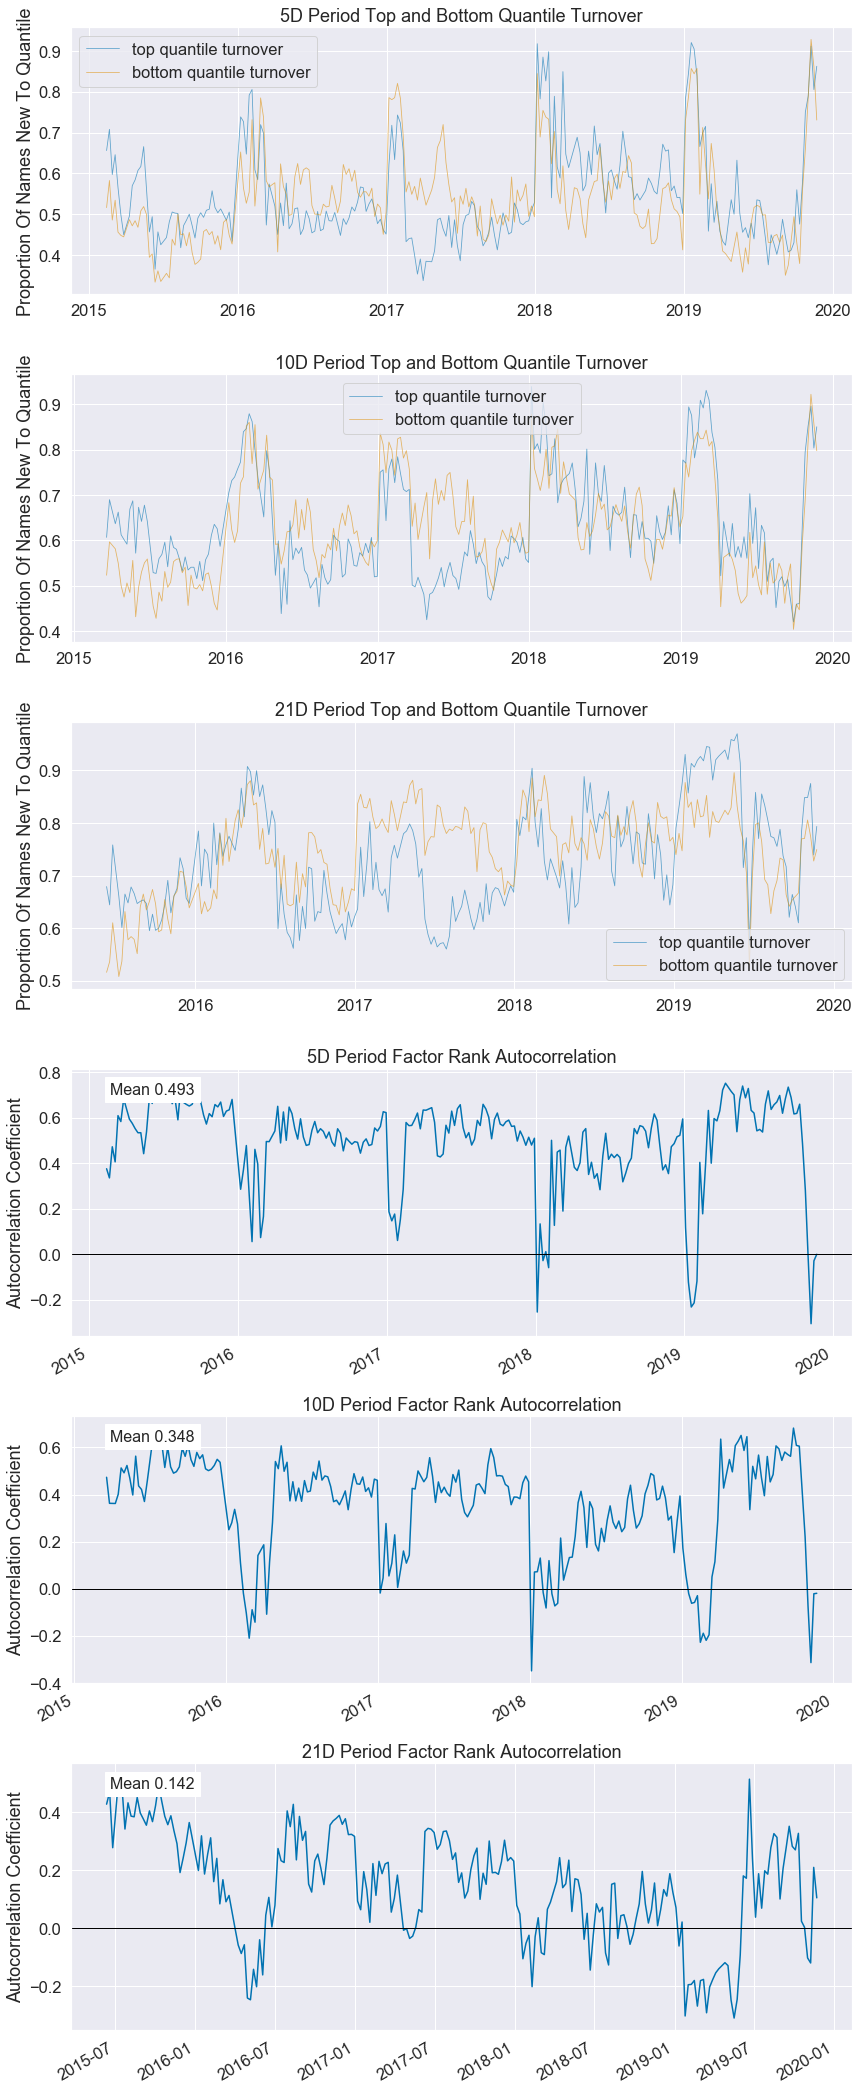

In [19]:
create_full_tear_sheet(factor_data)